In [1]:
import os
import pickle
from glob import glob
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
base_path = "datasets"
dataframe = pd.DataFrame()
for filename in os.listdir(base_path):
    df = pd.read_pickle(f"{base_path}/{filename}")
    dataframe = pd.concat([dataframe, df], ignore_index=True)

print(dataframe)
X = dataframe.drop(columns=["label"])
y = dataframe["label"]

       label  activity_count  heart_rate_std  circadian_cycle  hour_of_sleep
0          0        0.000000        0.351612        -0.258819       0.000000
1          0        0.000000        0.336348        -0.260926       0.008333
2          0        0.000000        0.322797        -0.263031       0.016667
3          0        0.001274        0.310572        -0.265135       0.025000
4          0        0.009708        0.299694        -0.267238       0.033333
...      ...             ...             ...              ...            ...
25487      0       39.463964        1.354808        -0.969231       5.950000
25488      0       45.298359        1.305649        -0.968692       5.958333
25489      0       49.129194        1.256232        -0.968148       5.966667
25490      0       50.419222        1.257577        -0.967599       5.975000
25491      0       49.070902        1.309048        -0.967046       5.983333

[25492 rows x 5 columns]


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# clf = RandomForestClassifier(n_estimators=200, max_depth=30, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
# Train accuracy: 1.0000
# Test accuracy: 0.8236
# clf = RandomForestClassifier(n_estimators=200, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, random_state=42)
# Train accuracy: 0.9677
# Test accuracy: 0.8226
# clf = RandomForestClassifier(n_estimators=200, max_depth=15, max_features=None, min_samples_leaf=3, min_samples_split=2, random_state=42)
# Train accuracy: 0.9019
# Test accuracy: 0.8103
# sel:
# Train accuracy: 0.8692
# Test accuracy: 0.7967

# model bardzo często rozpoznawał klasę 1, a pomijał 0 oraz 2 - stąd wagi
clf = RandomForestClassifier(n_estimators=200, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=2, random_state=42, class_weight={0: 2, 1: 1, 2: 2})
# Train accuracy: 0.8003
# Test accuracy: 0.7746
# sel:
# Train accuracy: 0.7877
# Test accuracy: 0.7687
# wagi klas:
# Train accuracy: 0.7741
# Test accuracy: 0.7493

# Redukcja liczby cech / selekcja cech
# sfm = SelectFromModel(clf).fit(X_train, y_train)
# X_train_sel = sfm.transform(X_train)
# X_test_sel = sfm.transform(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       433
           1       0.86      0.80      0.83      3558
           2       0.52      0.68      0.59      1108

    accuracy                           0.75      5099
   macro avg       0.69      0.68      0.68      5099
weighted avg       0.77      0.75      0.76      5099

0.7525004902922141


In [64]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1 score:", f1_score(y_test, y_pred, average='macro'))

Balanced accuracy: 0.683197388894209
Macro F1 score: 0.6817841974766803


In [65]:
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.7900
Test accuracy: 0.7525


In [73]:
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': ["activity_count", "heart_rate_std", "circadian_cycle", "hour_of_sleep"],
    'Gini Importance': importances}
).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

           Feature  Gini Importance
1   heart_rate_std         0.389202
3    hour_of_sleep         0.262685
0   activity_count         0.181147
2  circadian_cycle         0.166965


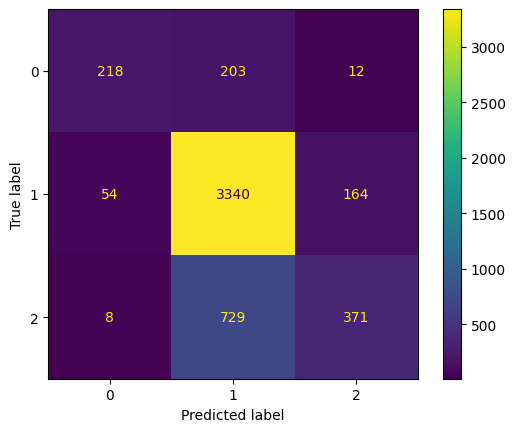

In [56]:
# bez zbalansowania klas
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

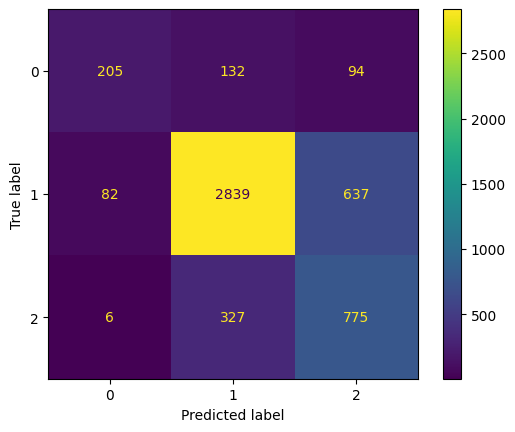

In [59]:
# class_weight={0: 3, 1: 1, 2: 2}
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

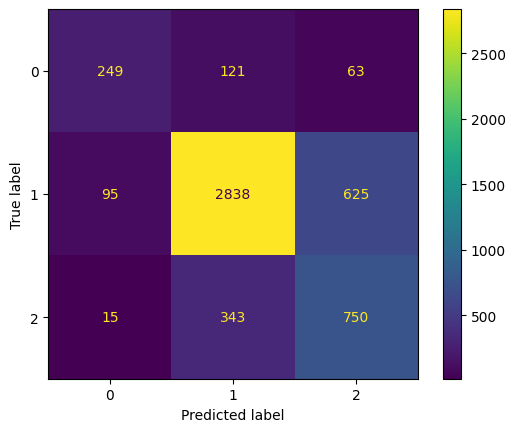

In [66]:
# class_weight={0: 2, 1: 1, 2: 2}
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

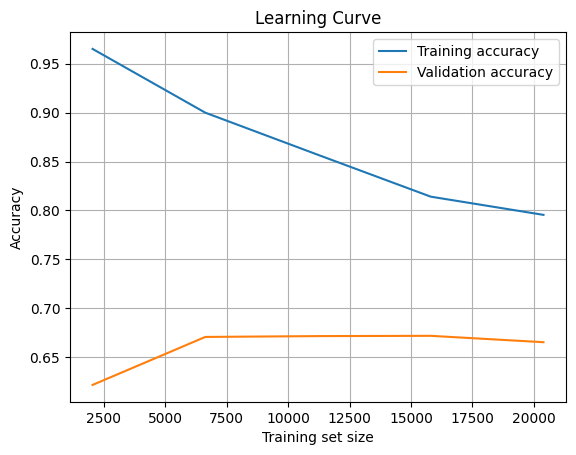

In [67]:
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, test_mean, label='Validation accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [68]:
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("CV mean accuracy:", scores.mean())
print("CV std:", scores.std())

CV mean accuracy: 0.6655013856285024
CV std: 0.025929187574490708


Testowanie różnych modeli i ich wariantów

C:\Users\Gabi\PycharmProjects\sleep_classifiers\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7861487149303512
              precision    recall  f1-score   support

           0       0.83      0.51      0.63       431
           1       0.81      0.92      0.86      3558
           2       0.65      0.46      0.54      1108

    accuracy                           0.79      5097
   macro avg       0.76      0.63      0.68      5097
weighted avg       0.78      0.79      0.77      5097

Train accuracy: 0.8377
Test accuracy: 0.7861


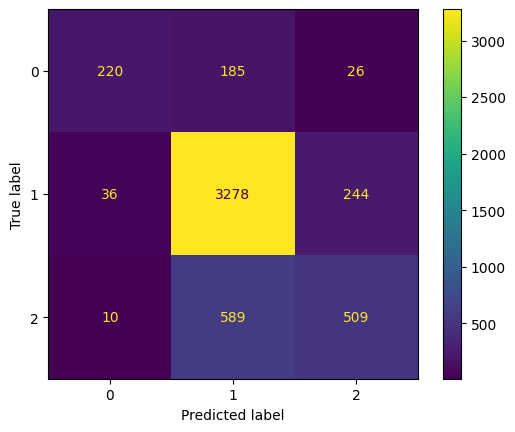

In [91]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weights = dict(zip(np.unique(y_train), class_weights))
print(scale_pos_weights)

xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weights,
    random_state=42
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_accuracy = xgb_clf.score(X_train, y_train)
test_accuracy = xgb_clf.score(X_test, y_test)
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

XGBoost Accuracy: 0.8059642927212085
              precision    recall  f1-score   support

           0       0.69      0.54      0.61       412
           1       0.84      0.91      0.87      3563
           2       0.70      0.59      0.64      1122

    accuracy                           0.81      5097
   macro avg       0.74      0.68      0.71      5097
weighted avg       0.80      0.81      0.80      5097

Train accuracy: 0.9243
Test accuracy: 0.8060


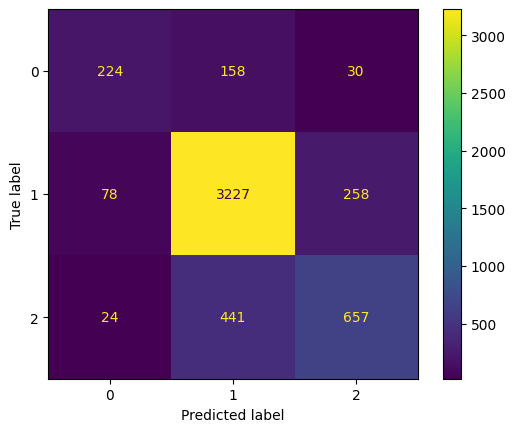

In [127]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=18,
    learning_rate=0.001,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_accuracy = xgb_clf.score(X_train, y_train)
test_accuracy = xgb_clf.score(X_test, y_test)
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encoding etykiet
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_cat,
                    epochs=40,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])

# Ewaluacja
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Epoch 1/40


C:\Users\Gabi\PycharmProjects\sleep_classifiers\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4202 - loss: 2.0462 - val_accuracy: 0.5009 - val_loss: 1.4453
Epoch 2/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6533 - loss: 1.4097 - val_accuracy: 0.7317 - val_loss: 1.1200
Epoch 3/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6601 - loss: 1.3427 - val_accuracy: 0.7361 - val_loss: 1.1156
Epoch 4/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6745 - loss: 1.2698 - val_accuracy: 0.7366 - val_loss: 1.0991
Epoch 5/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6779 - loss: 1.2396 - val_accuracy: 0.7412 - val_loss: 1.0805
Epoch 6/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6858 - loss: 1.2037 - val_accuracy: 0.7390 - val_loss: 1.0688
Epoch 7/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6851 - loss: 1.1945 - val_accuracy: 0.7351 - val_loss: 1.0565
Epoch 8/40
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6935 - loss: 1.1618 - val_accuracy: 0.7393 - val_

In [13]:
mlp = MLPClassifier(activation='relu',
              hidden_layer_sizes=(15, 15, 15),
              max_iter=1000, alpha=0.01, solver='lbfgs')
mlp.fit(X_train_scaled, y_train_cat)

y_pred_proba = mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 73.16%
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.55      0.50       431
           1       0.78      0.90      0.84      3558
           2       0.60      0.27      0.38      1108

    accuracy                           0.73      5097
   macro avg       0.61      0.57      0.57      5097
weighted avg       0.72      0.73      0.71      5097



In [14]:
mlp = MLPClassifier(activation='relu',
                    hidden_layer_sizes=(50, 50, 50),  # Zwiększenie liczby neuronów i warstw
                    max_iter=1000, alpha=0.01, solver='adam', random_state=42)
mlp.fit(X_train_scaled, y_train_cat)

y_pred_proba = mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 73.49%


In [17]:
mlp = MLPClassifier(activation='relu',
                      hidden_layer_sizes=(100, 100, 100, 100),  # Więcej warstw
                      max_iter=1000, alpha=0.01, solver='adam', random_state=42)
mlp.fit(X_train_scaled, y_train_cat)

y_pred_proba = mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 75.44%


In [22]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7522071806945262


In [23]:
svc = SVC(kernel='rbf', C=1, gamma='scale')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.709240729841083


In [37]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf)], voting='hard')
voting_clf.fit(X_train_scaled, y_train)
y_pred = voting_clf.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.7761428291151657


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.8187168922895821


In [34]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'max_depth': 37, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 557}


In [39]:
# Best parameters found:
# max_depth=37
# max_features='sqrt'
# min_samples_leaf=1
# min_samples_split=2
# n_estimators=557
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8220521875613106


In [45]:
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2)
random_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", random_search.best_params_)
best_model_scaled = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 686}


In [49]:
y_pred = best_model_scaled.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.8220521875613106


In [47]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_model_grid = grid_search.best_estimator_


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [50]:
y_pred = best_model_grid.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.8220521875613106


In [54]:
clf = RandomForestClassifier(max_depth=100, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = best_model_grid.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.8220521875613106


In [6]:
id_ = 46343
# features = []
# for suffix in feature_suffixes:
#     file_path = os.path.join(base_path, f"{id_}_{suffix}.out")
#     if not os.path.exists(file_path):
#         raise FileNotFoundError(f"Brakuje pliku: {file_path}")
#     data = np.loadtxt(file_path)
#     features.append(data)
#
# label_path = os.path.join(base_path, f"{id_}_{label_suffix}.out")
# if not os.path.exists(label_path):
#     raise FileNotFoundError(f"Brakuje pliku: {label_path}")
# labels = np.loadtxt(label_path).astype(int)

# Sprawdź, czy wszystkie cechy mają tyle samo próbek
# min_len = min(len(f) for f in features + [labels])
# features = [f[:min_len] for f in features]
# labels = labels[:min_len]
# labels = np.array([mapping[x] for x in labels])
with open(r"datasets/data_46343.pkl", "rb") as input_file:
    data = pickle.load(input_file)
X = data.drop("label", axis=1)
labels = data["label"]
clf_loaded = load('model.joblib')
# X = np.stack(features, axis=1)

y_pred = clf_loaded.predict(X)
print(accuracy_score(labels, y_pred))
for i in range(y_pred.shape[0]):
    print(f"value: {list(labels)[i]}, prediction: {y_pred[i]}")

0.7920433996383364
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 0
value: 0, prediction: 1
value: 0, prediction: 1
value: 0, prediction: 0
value: 0, prediction: 1
value: 0, prediction: 1
value: 1, prediction: 1
value: 1, prediction: 1
value: 1, prediction: 1
value: 1, prediction: 1
value: 1, prediction: 1
value: 1, prediction: 1
value: 1, prediction:

In [59]:
folder = 'outputs/features'

# Zbiór plików
cosine_files = sorted(glob(os.path.join(folder, '*_cosine_feature.out')))
count_files = sorted(glob(os.path.join(folder, '*_count_feature.out')))
hr_files = sorted(glob(os.path.join(folder, '*_hr_feature.out')))
time_files = sorted(glob(os.path.join(folder, '*_time_feature.out')))
label_files = sorted(glob(os.path.join(folder, '*_psg_labels.out')))

# Wyciągnięcie ID
ids = [os.path.basename(f).split('_')[0] for f in cosine_files]
unique_ids = sorted(list(set(ids)))

print(f"Znaleziono {len(unique_ids)} unikalnych ID: {unique_ids}")

# WYBIERZEMY 3 ID do testu
test_ids = unique_ids[:3]  # np. pierwsze 3 ID
train_ids = unique_ids[3:]

print(f"Test IDs: {test_ids}")
print(f"Train IDs: {train_ids}")

# Funkcja wczytująca dane dla ID
def load_data_for_ids(ids_list):
    X = []
    y = []

    for id_ in ids_list:
        cos_f = os.path.join(folder, f"{id_}_cosine_feature.out")
        count_f = os.path.join(folder, f"{id_}_count_feature.out")
        hr_f = os.path.join(folder, f"{id_}_hr_feature.out")
        time_f = os.path.join(folder, f"{id_}_time_feature.out")
        label_f = os.path.join(folder, f"{id_}_psg_labels.out")

        cosine = np.loadtxt(cos_f)
        count = np.loadtxt(count_f)
        hr = np.loadtxt(hr_f)
        time = np.loadtxt(time_f)
        labels = np.loadtxt(label_f)

        # Stack cech
        features = np.stack([cosine, count, hr, time], axis=1)

        X.append(features)
        y.append(labels)

    return X, y

# Załaduj dane
X_train_seq, y_train_seq = load_data_for_ids(train_ids)
X_test_seq, y_test_seq = load_data_for_ids(test_ids)

print(f"Liczba nocy treningowych: {len(X_train_seq)}")
print(f"Liczba nocy testowych: {len(X_test_seq)}")


Znaleziono 31 unikalnych ID: ['1066528', '1360686', '1449548', '1455390', '1818471', '2598705', '2638030', '3509524', '3997827', '4018081', '4314139', '4426783', '46343', '5132496', '5383425', '5498603', '5797046', '6220552', '759667', '7749105', '781756', '8000685', '8173033', '8258170', '844359', '8530312', '8686948', '8692923', '9106476', '9618981', '9961348']
Test IDs: ['1066528', '1360686', '1449548']
Train IDs: ['1455390', '1818471', '2598705', '2638030', '3509524', '3997827', '4018081', '4314139', '4426783', '46343', '5132496', '5383425', '5498603', '5797046', '6220552', '759667', '7749105', '781756', '8000685', '8173033', '8258170', '844359', '8530312', '8686948', '8692923', '9106476', '9618981', '9961348']
Liczba nocy treningowych: 28
Liczba nocy testowych: 3


In [61]:
# Padding X i y (do max długości)
max_len = max([x.shape[0] for x in X_train_seq + X_test_seq])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, dtype='float32', padding='post')
y_train_padded = pad_sequences(y_train_seq, maxlen=max_len, dtype='int32', padding='post')

X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, dtype='float32', padding='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=max_len, dtype='int32', padding='post')

print(f"Nowe kształty: {X_train_padded.shape}, {y_train_padded.shape}")

Nowe kształty: (28, 978, 4), (28, 978)


In [62]:
model = Sequential([
    Masking(mask_value=0., input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    LSTM(64, return_sequences=True),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')  # 6 klas snu: 0-5
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_padded, y_train_padded,
                    epochs=30,
                    batch_size=8,
                    validation_split=0.2)

C:\Users\Gabi\PycharmProjects\sleep_classifiers\venv\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 565ms/step - accuracy: 0.2509 - loss: 1.7560 - val_accuracy: 0.5065 - val_loss: 1.6095
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - accuracy: 0.4297 - loss: 1.5844 - val_accuracy: 0.5191 - val_loss: 1.5125
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.4251 - loss: 1.4958 - val_accuracy: 0.5215 - val_loss: 1.4569
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - accuracy: 0.4235 - loss: 1.4489 - val_accuracy: 0.5216 - val_loss: 1.4199
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.4278 - loss: 1.3960 - val_accuracy: 0.5218 - val_loss: 1.3946
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.4427 - loss: 1.3568 - val_accuracy: 0.5210 - val_loss: 1.3715
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.4378 - loss: 1.3214 - val_accuracy: 0.5208 - val_loss: 1.3494
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.4244 - loss: 1.3234 - val_accuracy: 0.5220 - val_loss:

In [63]:
y_pred_proba = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_proba, axis=-1)

y_pred_flat = y_pred.flatten()
y_true_flat = y_test_padded.flatten()

mask = y_true_flat != 0  # lub != -1 zależnie od tego jak padujesz
acc = accuracy_score(y_true_flat[mask], y_pred_flat[mask])

print("Accuracy:", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Accuracy: 0.5553618134263295


# Najlepszy model


In [75]:
clf = RandomForestClassifier(n_estimators=200, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=2, random_state=42, class_weight={0: 2, 1: 1, 2: 2})
clf.fit(X_train, y_train)

dump(clf, 'model.joblib')

['model.joblib']

In [4]:
clf_loaded = load('model.joblib')
y_pred = clf_loaded.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.7525004902922141
